In [2]:
%matplotlib inline
%matplotlib widget

from shutil import move
import sys
from fastai.vision.augment import TypeDispatch
from fastcore.basics import store_attr

from torch.nn.functional import interpolate

sys.path += [".."]
import os

os.getcwd()
from fran.utils.helpers import *

In [ ]:
# # temporary hack to allow me to use ipython console as well as notebook for same code
if is_notebook() == False:
    os.chdir("nbs")

In [3]:
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
from common_imports import *
from fran.preprocessing.stage0_preprocessors import *
from fran.preprocessing.stage1_preprocessors import *

common_paths_filename = "config.yaml"
proj_defaults = load_proj_defaults(common_paths_filename, "kits21")

#

# Preprocessing stage0 : All images and masks are resampled to median spacing of the dataset by default.

In [ ]:

R = ResampleDatasetNiftyToTorch(
    proj_defaults, minimum_final_spacing=0.0, enforce_isotropy=False
)

In [ ]:
R.spacings = [
    1.0,
]

In [ ]:
R.resample_cases(debug=True, overwrite=True, multiprocess=True, clip_center=True)

## The cold-storage/spc_x_y_z folder is populated with resampled tensors, images under imagesTr, and masks under masksTr

In [ ]:
masks_folder = R.resampling_output_folder / ("masksTr")
imgs_folder = R.resampling_output_folder / ("imagesTr")

resampled_imgs = list((R.resampling_output_folder / ("imagesTr")).glob("*pt"))
resampled_masks = list((R.resampling_output_folder / ("masksTr")).glob("*pt"))

In [ ]:
img_fn = resampled_imgs[0]
mask_fn = resampled_masks[0].parent / (img_fn.name)

img = torch.load(img_fn)
mask = torch.load(mask_fn)
case_id = get_case_id_from_filename("kits21", img_fn)
print("Case_id:", case_id)

In [ ]:
ImageMaskViewer([img, mask], intensity_slider_range_percentile=[0, 100])

## You can view any case properties. Properties include bounding box limits (in this case the kidney region) and other relevant info.

In [ ]:
single_case_properties = [
    p for p in R.raw_dataset_properties if p["case_id"] == case_id
][0]
pp(single_case_properties)

# Having resampled all images to same resolution, now we obtain bounding boxes of the organ inside

In [ ]:
R.generate_bboxes()

# Check if the bboxes actually cover the organ

In [15]:
stats_fn = R.resampling_output_folder / "bboxes_info"
bbs = load_dict(stats_fn)
case_0 = bbs[0]
pp(case_0)

{'bbox_stats': [{'bounding_boxes': [(slice(0, 194, None),
                                     slice(0, 511, None),
                                     slice(0, 511, None)),
                                    (slice(38, 87, None),
                                     slice(285, 365, None),
                                     slice(257, 341, None)),
                                    (slice(56, 101, None),
                                     slice(115, 193, None),
                                     slice(235, 334, None))],
                 'centroids': array([[ 96.62734326, 255.07483463, 254.83562537],
       [ 61.48702887, 325.94735372, 298.03382227],
       [ 77.68203167, 154.83991991, 281.39395837]]),
                 'tissue_type': 'kidney',
                 'voxel_counts': array([50417969,   118147,   121358], dtype=uint64)},
                {'bounding_boxes': [(slice(0, 194, None),
                                     slice(0, 511, None),
                                   

In [16]:
organ = "kidney"
bboxes = case_0["bbox_stats"]
mask_fn = case_0["filename"]
img_fn = imgs_folder / mask_fn.name
mask = torch.load(mask_fn)
img = torch.load(img_fn)
pp(bboxes)
organ_bb_info = [b for b in bboxes if b["tissue_type"] == organ][0]
organ_bb_only = organ_bb_info["bounding_boxes"][
    1
]  # note index 1 is always the entire image

[{'bounding_boxes': [(slice(0, 194, None),
                      slice(0, 511, None),
                      slice(0, 511, None)),
                     (slice(38, 87, None),
                      slice(285, 365, None),
                      slice(257, 341, None)),
                     (slice(56, 101, None),
                      slice(115, 193, None),
                      slice(235, 334, None))],
  'centroids': array([[ 96.62734326, 255.07483463, 254.83562537],
       [ 61.48702887, 325.94735372, 298.03382227],
       [ 77.68203167, 154.83991991, 281.39395837]]),
  'tissue_type': 'kidney',
  'voxel_counts': array([50417969,   118147,   121358], dtype=uint64)},
 {'bounding_boxes': [(slice(0, 194, None),
                      slice(0, 511, None),
                      slice(0, 511, None)),
                     (slice(41, 50, None),
                      slice(283, 311, None),
                      slice(309, 337, None))],
  'centroids': array([[ 96.50411994, 254.99670099, 254.99467616],


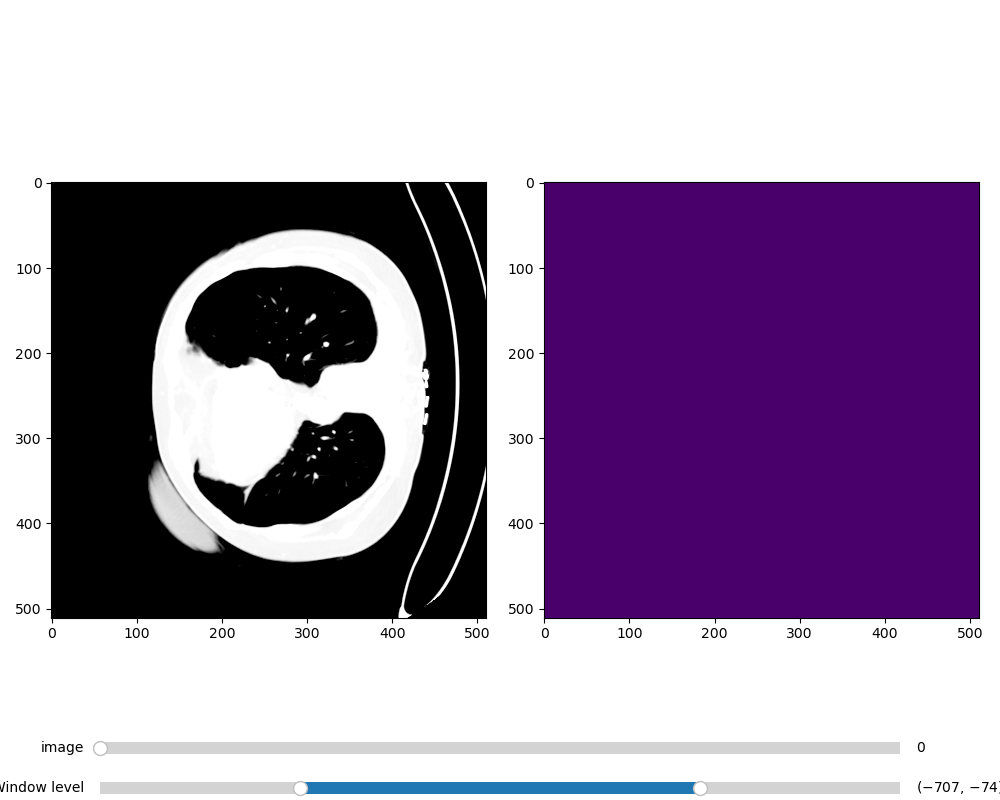

In [17]:
ImageMaskViewer([img, mask])

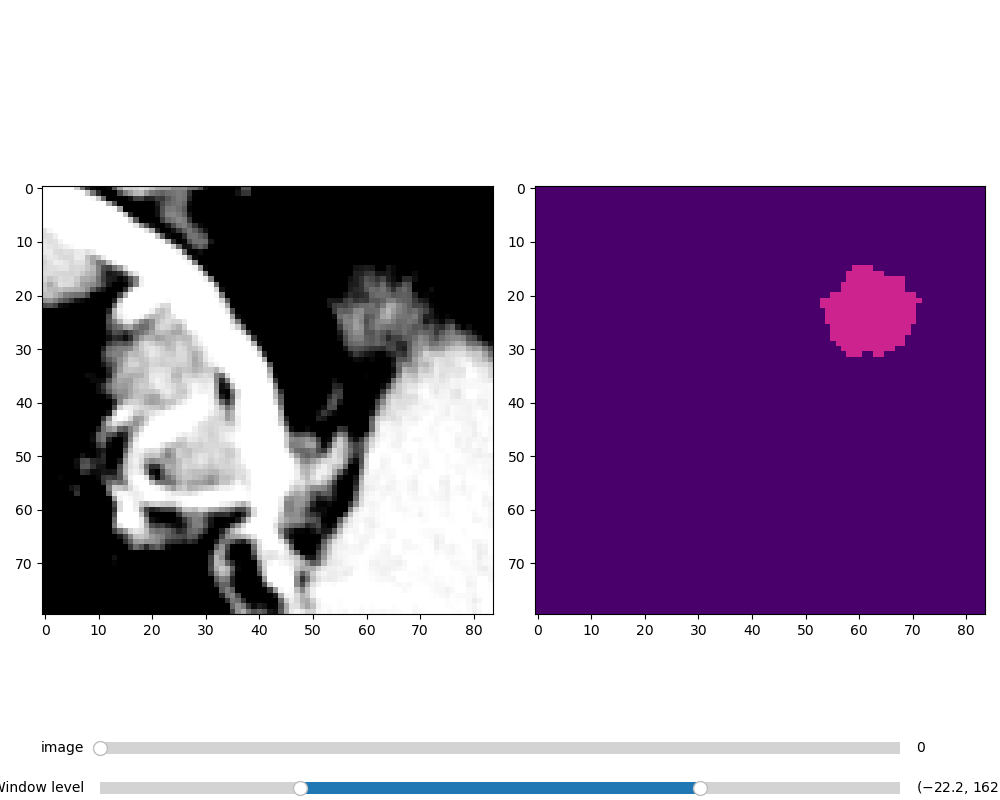

In [18]:
ImageMaskViewer([img[organ_bb_only], mask[organ_bb_only]])

# Numerous DL tasks include step 1: Identify organ containing tumour. Step 2: Identify tumour inside the organ\
## Preprocessing stage1 creates Low-res images of fixed dimension from the stage0 images. This is for Step1 above. The job of training on these images is to detect the organ of interest only (organ) and extract a boundingbox.
# Creates low res images

In [16]:
resampling_configs_fn = proj_defaults.fixed_spacings_folder / ("resampling_configs")
resampling_configs = load_dict(resampling_configs_fn)
target_spacings = [
    1.0,
] * 3
pp(resampling_configs)
input_folder = [
    conf["resampling_output_folder"]
    for conf in resampling_configs
    if conf["spacings"] == target_spacings
][0]

output_shape = [128, 128, 128]  # you can choose output_size to be any reasonable number


C = WholeImageTensorMaker(
    proj_defaults,
    source_spacings=[
        1.0,
    ]
    * 3,
    output_size=output_shape,
)
C.process_tensor()

# Creating bounding boxes for low-res images. Note: Low-res images are generally just for crude identification of the kidney. Bounding boxes are generated as a placeholder for the ImageMasBBoxDataset, but not used

In [26]:

C.store_bbox_info(debug=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:05<00:00, 51.62it/s]/home/ub/programs/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3406: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)



2022-11-05T22:13:50.162733+0000 - Timed out waiting for syncing to complete.
2022-11-05T22:13:55.207413+0000 - Timed out waiting for syncing to complete.
2022-11-05T22:14:00.251189+0000 - Timed out waiting for syncing to complete.
2022-11-05T22:14:05.295705+0000 - Timed out waiting for syncing to complete.


Exception ignored in: <Finalize object, dead>
Traceback (most recent call last):
  File "/home/ub/programs/miniconda3/lib/python3.9/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/ub/programs/miniconda3/lib/python3.9/multiprocessing/pool.py", line 729, in _terminate_pool
    p.join()
  File "/home/ub/programs/miniconda3/lib/python3.9/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/home/ub/programs/miniconda3/lib/python3.9/multiprocessing/popen_fork.py", line 43, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/home/ub/programs/miniconda3/lib/python3.9/multiprocessing/popen_fork.py", line 27, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


In [27]:
bb = load_dict(C.bbox_fn)
pp(bb[0])

Path('/home/ub/datasets/preprocessed/kits21/stage1_lowres/128_128_128/volumes')

# Preprocessing stage2: Create hi-res images based on stage0. These are cropped down to the organ (kidney), and each case has numerous patches based on patch size. In theory a very large patch size could cover the entire organ and the opposite is true for a very small (e.g., 32x32x32) patch size

In [19]:


output_folder = proj_defaults.patches_folder
resampling_configs_fn = proj_defaults.fixed_spacings_folder / ("resampling_configs.pkl")
spacings = load_dict(resampling_configs_fn)

spacings_config = spacings[0]
fixed_sp_folder = spacings_config["resampling_output_folder"]

In [25]:
stage0_bboxes_fn = fixed_sp_folder / ("bboxes_info")
stage0_bboxes = load_dict(stage0_bboxes_fn)
patch_size = [96, 160, 160]
patches_fldr_name = "dim_{0}_{1}_{2}".format(*patch_size)
stride = 1

In [26]:
output_folder = proj_defaults.patches_folder / fixed_sp_folder.name / patches_fldr_name
maybe_makedirs(output_folder)
expand_by = 30  # in mm
spacings = spacings_config["spacings"]
args = [[proj_defaults, output_folder, patch_size, inf, spacings, expand_by] for inf in stage0_bboxes]

In [28]:
res = multiprocess_multiarg(
    patch_generator_wrapper, args, debug=False, progress_bar=False
)

  0%|                                                                                                                                                                   | 0/300 [00:00<?, ?it/s]

Creating patches for case 00082Creating patches for case 00141Creating patches for case 00092Creating patches for case 00151Creating patches for case 00269
Creating patches for case 00139




Creating patches for case 00219Creating patches for case 00263

Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00082_0.pt


  0%|▌                                                                                                                                                          | 1/300 [00:00<03:07,  1.59it/s]

Creating patches for case 00021
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00151_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00151_1.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00141_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00151_2.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00151_3.pt


  1%|█                                                                                                                                                          | 2/300 [00:00<02:06,  2.35it/s]

Creating patches for case 00258
Creating patches for case 00278
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00263_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00263_1.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00021_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00092_0.pt
Creating patches for case 00071
Creating patches for case 00087
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00092_1.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00139_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00092_2.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00219_0.pt
Saving to file /home/ub/datasets

  1%|█▌                                                                                                                                                         | 3/300 [00:01<03:33,  1.39it/s]

Creating patches for case 00040
Creating patches for case 00275
Creating patches for case 00147
Creating patches for case 00119


  2%|███                                                                                                                                                        | 6/300 [00:02<01:18,  3.74it/s]

Creating patches for case 00158
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00158_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00040_0.pt
Creating patches for case 00298
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00240_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00004_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00040_1.pt
Creating patches for case 00225
Creating patches for case 00280
Creating patches for case 00185
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00119_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00119_1.pt
Creating patches for case 00042
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_16

  5%|███████▏                                                                                                                                                  | 14/300 [00:03<01:06,  4.29it/s]

Creating patches for case 00075
Creating patches for case 00256
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00275_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00280_0.pt
Creating patches for case 00265

  6%|█████████▏                                                                                                                                                | 18/300 [00:04<00:52,  5.40it/s]


Creating patches for case 00106
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00042_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00042_1.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00225_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00103_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00042_2.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00075_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00225_1.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00042_3.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00256_0.pt
Creating patches for c

  8%|███████████▊                                                                                                                                              | 23/300 [00:05<00:48,  5.68it/s]


Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00042_4.pt
Creating patches for case 00037
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00042_5.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00042_6.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00265_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00042_7.pt
Creating patches for case 00132
Creating patches for case 00055
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00160_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00185_0.pt
Creating patches for case 00183


  8%|████████████▊                                                                                                                                             | 25/300 [00:05<00:52,  5.27it/s]

Creating patches for case 00203
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00070_0.pt
Creating patches for case 00170
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00106_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00132_0.pt
Creating patches for case 00207


 10%|███████████████▉                                                                                                                                          | 31/300 [00:05<00:38,  7.08it/s]

Creating patches for case 00068
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00183_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00290_0.pt
Creating patches for case 00220
Creating patches for case 00163

 11%|█████████████████▍                                                                                                                                        | 34/300 [00:06<00:33,  7.96it/s]


Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00068_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00203_0.pt
Creating patches for case 00162
Creating patches for case 00197
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00037_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00055_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00037_1.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00055_1.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00037_2.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00162_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_0

 12%|██████████████████▍                                                                                                                                       | 36/300 [00:07<01:03,  4.18it/s]


Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00207_0.pt
Creating patches for case 00097
Creating patches for case 00020
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00163_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00163_1.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00251_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00249_0.pt
Creating patches for case 00195
Creating patches for case 00276
Creating patches for case 00161
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00197_0.pt
Creating patches for case 00268
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00170_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_1

 13%|████████████████████▌                                                                                                                                     | 40/300 [00:08<01:05,  3.97it/s]

Creating patches for case 00246
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00097_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00268_0.pt
Creating patches for case 00247
Creating patches for case 00011
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00208_0.pt


 16%|████████████████████████▋                                                                                                                                 | 48/300 [00:09<00:38,  6.49it/s]

Creating patches for case 00019
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00161_0.pt
Creating patches for case 00015
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00020_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00276_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00195_0.pt
Creating patches for case 00058


 17%|██████████████████████████▏                                                                                                                               | 51/300 [00:09<00:36,  6.90it/s]

Creating patches for case 00117
Creating patches for case 00264
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00015_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00011_0.pt
Creating patches for case 00239
Creating patches for case 00165
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00246_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00117_0.pt


 19%|████████████████████████████▋                                                                                                                             | 56/300 [00:10<00:33,  7.33it/s]

Creating patches for case 00052
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00117_1.pt
Creating patches for case 00074
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00264_0.pt
Creating patches for case 00116
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00074_0.pt
Creating patches for case 00164Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00116_0.pt

Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00019_0.pt
Creating patches for case 00114
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00247_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00239_0.pt
Creating patches for case 00205


 19%|█████████████████████████████▎                                                                                                                            | 57/300 [00:11<00:57,  4.24it/s]

Creating patches for case 00176
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00052_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00239_1.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00058_0.pt
Creating patches for case 00022
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00058_1.pt
Creating patches for case 00101


 20%|███████████████████████████████▎                                                                                                                          | 61/300 [00:11<00:45,  5.30it/s]

Creating patches for case 00232
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00164_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00114_0.pt
Creating patches for case 00168
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00114_1.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00114_2.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00114_3.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00022_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00101_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00205_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00

 22%|█████████████████████████████████▎                                                                                                                        | 65/300 [00:12<00:50,  4.63it/s]



Creating patches for case 00046
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00232_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00232_1.pt
Creating patches for case 00005
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00110_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00016_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00176_0.pt
Creating patches for case 00067
Creating patches for case 00111


 24%|████████████████████████████████████▉                                                                                                                     | 72/300 [00:13<00:36,  6.21it/s]

Creating patches for case 00266
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00259_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00172_0.pt
Creating patches for case 00027
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00172_1.pt
Creating patches for case 00299

 26%|████████████████████████████████████████                                                                                                                  | 78/300 [00:13<00:27,  8.18it/s]


Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00067_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00067_1.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00067_2.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00067_3.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00067_4.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00067_5.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00067_6.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00067_7.pt
Creating patches for case 00296
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00266_0.pt
Creating patches for c

 27%|█████████████████████████████████████████                                                                                                                 | 80/300 [00:14<00:38,  5.73it/s]

Creating patches for case 00017
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00046_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00005_0.pt
Creating patches for case 00293


 27%|██████████████████████████████████████████                                                                                                                | 82/300 [00:15<00:34,  6.33it/s]

Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00005_1.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00005_2.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00027_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00005_3.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00115_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00296_0.pt
Creating patches for case 00137
Creating patches for case 00003
Creating patches for case 00007
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00064_0.pt


 28%|██████████████████████████████████████████▌                                                                                                               | 83/300 [00:15<00:35,  6.03it/s]

Creating patches for case 00018
Creating patches for case 00223
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00293_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00293_1.pt
Creating patches for case 00267
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00017_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00137_0.pt
Creating patches for case 00080
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00007_0.pt
Creating patches for case 00200
Creating patches for case 00244
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00003_0.pt
Creating patches for case 00192
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00267_0.pt
Saving to file /home/ub/datasets/preproce

 31%|███████████████████████████████████████████████▏                                                                                                          | 92/300 [00:16<00:29,  7.08it/s]

Creating patches for case 00233
Creating patches for case 00237
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00244_0.pt
Creating patches for case 00081
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00080_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00200_0.pt
Creating patches for case 00286
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00091_0.pt
Creating patches for case 00235
Creating patches for case 00248
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00237_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00233_0.pt
Creating patches for case 00088
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00233_1.pt
Saving to file /home/ub/datasets/preproce

 33%|██████████████████████████████████████████████████▊                                                                                                       | 99/300 [00:21<01:17,  2.61it/s]

Creating patches for case 00143
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00177_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00030_0.pt
Creating patches for case 00057
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00289_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00030_1.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00030_2.pt
Creating patches for case 00144
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00030_3.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00030_4.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00030_5.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patc

 43%|█████████████████████████████████████████████████████████████████▎                                                                                       | 128/300 [00:23<00:27,  6.32it/s]

Creating patches for case 00109
Creating patches for case 00149
Creating patches for case 00209Creating patches for case 00261

Creating patches for case 00059
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00109_0.pt
Creating patches for case 00130
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00012_0.pt
Creating patches for case 00033
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00066_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00130_0.pt
Creating patches for case 00029


 46%|██████████████████████████████████████████████████████████████████████▉                                                                                  | 139/300 [00:24<00:20,  7.67it/s]

Creating patches for case 00077
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00096_0.pt
Creating patches for case 00262
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00149_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00149_1.pt


 48%|█████████████████████████████████████████████████████████████████████████▍                                                                               | 144/300 [00:24<00:18,  8.46it/s]

Creating patches for case 00123
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00261_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00059_0.pt
Creating patches for case 00202
Creating patches for case 00045
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00262_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00262_1.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00209_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00262_2.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00262_3.pt


 49%|██████████████████████████████████████████████████████████████████████████▍                                                                              | 146/300 [00:25<00:21,  7.25it/s]

Creating patches for case 00254
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00077_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00045_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00033_0.pt
Creating patches for case 00150
Creating patches for case 00118
Creating patches for case 00010
Creating patches for case 00133


 50%|███████████████████████████████████████████████████████████████████████████▉                                                                             | 149/300 [00:25<00:18,  8.00it/s]

Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00010_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00029_0.pt
Creating patches for case 00282
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00029_1.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00254_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00254_1.pt
Creating patches for case 00098


 50%|█████████████████████████████████████████████████████████████████████████████                                                                            | 151/300 [00:25<00:21,  6.86it/s]

Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00150_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00123_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00150_1.pt
Creating patches for case 00236


 51%|██████████████████████████████████████████████████████████████████████████████                                                                           | 153/300 [00:25<00:20,  7.21it/s]

Creating patches for case 00041
Creating patches for case 00166
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00202_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00118_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00098_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00041_0.pt
Creating patches for case 00271
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00041_1.pt


 52%|███████████████████████████████████████████████████████████████████████████████                                                                          | 155/300 [00:26<00:21,  6.73it/s]

Creating patches for case 00171
Creating patches for case 00169
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00282_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00133_0.pt
Creating patches for case 00215
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00166_0.ptCreating patches for case 00255



 53%|█████████████████████████████████████████████████████████████████████████████████▌                                                                       | 160/300 [00:26<00:15,  8.77it/s]

Creating patches for case 00061
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00271_0.pt
Creating patches for case 00014
Creating patches for case 00044
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00236_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00236_1.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00236_2.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00236_3.pt


 54%|███████████████████████████████████████████████████████████████████████████████████▏                                                                     | 163/300 [00:27<00:17,  7.79it/s]

Creating patches for case 00136
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00061_0.pt
Creating patches for case 00287
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00169_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00287_0.pt
Creating patches for case 00108
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00215_0.pt
Creating patches for case 00120
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00255_0.pt
Creating patches for case 00146Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00171_0.pt

Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00014_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00171_1.pt


 56%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                   | 167/300 [00:28<00:23,  5.54it/s]

Creating patches for case 00226
Creating patches for case 00156
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00108_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00146_0.pt
Creating patches for case 00189
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00120_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00050_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00090_0.pt
Creating patches for case 00292
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00044_0.pt
Creating patches for case 00013
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00044_1.pt
Creating patches for case 00009
Creating patches for case 00095


 58%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 173/300 [00:28<00:18,  6.94it/s]

Creating patches for case 00167
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00013_0.pt
Creating patches for case 00228
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00009_0.pt
Creating patches for case 00206
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00226_0.pt


 60%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 181/300 [00:30<00:18,  6.56it/s]

Creating patches for case 00281
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00292_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00189_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00156_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00189_1.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00292_1.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00292_2.pt
Creating patches for case 00272
Creating patches for case 00227

 61%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                            | 182/300 [00:30<00:18,  6.30it/s]


Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00292_3.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00292_4.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00292_5.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00292_6.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00292_7.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00095_0.pt


 61%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 184/300 [00:30<00:17,  6.60it/s]

Creating patches for case 00191
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00228_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00167_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00228_1.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00167_1.pt


 62%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 187/300 [00:30<00:13,  8.13it/s]

Creating patches for case 00238
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00206_0.pt
Creating patches for case 00129
Creating patches for case 00100
Creating patches for case 00152
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00281_0.pt


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 191/300 [00:30<00:10, 10.44it/s]

Creating patches for case 00034
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00152_0.pt
Creating patches for case 00054
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00129_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00272_0.pt
Creating patches for case 00273
Creating patches for case 00188
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00191_0.pt
Creating patches for case 00140
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00227_0.pt


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 193/300 [00:31<00:17,  5.96it/s]

Creating patches for case 00142
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00273_0.pt
Creating patches for case 00159
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00238_0.pt
Creating patches for case 00155

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 195/300 [00:32<00:18,  5.63it/s]


Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00188_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00100_0.pt
Creating patches for case 00065


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 197/300 [00:32<00:15,  6.57it/s]

Creating patches for case 00274
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00140_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00034_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00142_0.pt
Creating patches for case 00277
Creating patches for case 00093


 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 199/300 [00:32<00:15,  6.70it/s]

Creating patches for case 00026
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00159_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00159_1.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00155_0.pt
Creating patches for case 00084
Creating patches for case 00157
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00065_0.pt
Creating patches for case 00179
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00277_0.pt
Creating patches for case 00043
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00054_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00054_1.pt


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                   | 200/300 [00:33<00:27,  3.65it/s]

Creating patches for case 00180
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00157_0.pt
Creating patches for case 00182
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00093_0.pt
Creating patches for case 00224
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00179_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00274_0.pt
Creating patches for case 00025
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00274_1.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00180_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00043_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00274_2.pt
Creating patches for case 00153


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 208/300 [00:35<00:19,  4.62it/s]

Creating patches for case 00174
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00026_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00025_1.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00153_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00084_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00026_1.pt
Creating patches for case 00173
Creating patches for case 00222
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00199_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00084_1.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00174_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patc

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 211/300 [00:35<00:19,  4.59it/s]

Creating patches for case 00131
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00222_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00051_0.pt
Creating patches for case 00257
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00023_0.pt
Creating patches for case 00126
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00023_1.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00173_0.pt
Creating patches for case 00194
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00253_0.pt


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 223/300 [00:36<00:10,  7.42it/s]

Creating patches for case 00218
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00131_0.pt
Creating patches for case 00072
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00257_0.pt
Creating patches for case 00099
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00127_0.pt
Creating patches for case 00234
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00127_1.pt


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 226/300 [00:37<00:09,  8.04it/s]

Creating patches for case 00048
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00284_0.pt


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 227/300 [00:37<00:09,  7.65it/s]

Creating patches for case 00187
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00072_0.pt
Creating patches for case 00104
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00234_0.pt
Creating patches for case 00124
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00187_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00187_1.pt
Creating patches for case 00216
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00099_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00099_1.pt
Creating patches for case 00181
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00194_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00218_0.pt


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 232/300 [00:38<00:13,  4.93it/s]

Creating patches for case 00217
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00048_0.pt


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 238/300 [00:39<00:08,  7.13it/s]

Creating patches for case 00145
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00216_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00104_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00216_1.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00181_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00124_0.pt
Creating patches for case 00294


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 240/300 [00:39<00:08,  7.39it/s]

Creating patches for case 00138
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00181_1.pt
Creating patches for case 00279
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00181_2.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00181_3.pt


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 243/300 [00:39<00:06,  8.38it/s]

Creating patches for case 00121
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00279_0.pt
Creating patches for case 00285
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00138_0.pt
Creating patches for case 00035
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00217_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00198_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00285_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00294_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00145_0.pt
Creating patches for case 00102
Creating patches for case 00134
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00145_1.pt


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 245/300 [00:40<00:11,  4.95it/s]

Creating patches for case 00053
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00134_0.pt
Creating patches for case 00135
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00102_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00102_1.pt
Creating patches for case 00001
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00053_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00175_0.pt
Creating patches for case 00112
Creating patches for case 00047
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00035_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00086_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00105_0.pt


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 253/300 [00:42<00:08,  5.34it/s]

Creating patches for case 00229
Creating patches for case 00213
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00135_1.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00001_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00250_1.pt
Creating patches for case 00252
Creating patches for case 00039
Creating patches for case 00291


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 256/300 [00:42<00:07,  5.99it/s]

Creating patches for case 00154
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00229_0.pt
Creating patches for case 00079
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00283_0.pt
Creating patches for case 00085
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00252_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00252_1.pt
Creating patches for case 00113
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00039_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00154_0.pt
Creating patches for case 00186
Creating patches for case 00211
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00213_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_16

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 264/300 [00:44<00:07,  5.08it/s]

Creating patches for case 00125
Creating patches for case 00036
Creating patches for case 00056
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00085_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00291_0.pt
Creating patches for case 00083
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00211_0.pt


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 270/300 [00:44<00:04,  6.44it/s]

Creating patches for case 00178
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00211_1.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00211_2.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00211_3.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00211_4.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00186_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00211_5.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00211_6.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00186_1.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00056_0.pt
Saving to file /home/ub

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 275/300 [00:46<00:04,  5.23it/s]

Creating patches for case 00210
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00056_2.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00056_3.pt
Creating patches for case 00063
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00178_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00245_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00178_1.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00245_1.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00245_2.pt
Creating patches for case 00270
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00125_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patc

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 277/300 [00:47<00:05,  4.07it/s]

Creating patches for case 00204
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00049_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00000_0.pt
Creating patches for case 00060
Creating patches for case 00122


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 283/300 [00:47<00:02,  5.77it/s]

Creating patches for case 00212
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00270_0.pt


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 288/300 [00:47<00:01,  7.33it/s]

Creating patches for case 00107
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00002_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00204_0.pt
Creating patches for case 00201
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00122_0.pt
Creating patches for case 00148
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00212_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00295_0.pt
Creating patches for case 00241
Creating patches for case 00196
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00201_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00107_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00060_0.pt


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 290/300 [00:49<00:02,  4.31it/s]

Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00241_0.pt
Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00241_1.pt


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 299/300 [00:49<00:00,  7.83it/s]

Saving to file /home/ub/datasets/preprocessed/kits21/stage2_patches/64_160_160/volumes/kits21_00196_0.pt


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:49<00:00,  6.05it/s]


[(1,
  Path('/home/ub/datasets/preprocessed/kits21/stage0_resampled/volumes/kits21_00082.pt')),
 (1,
  Path('/home/ub/datasets/preprocessed/kits21/stage0_resampled/volumes/kits21_00141.pt')),
 (1,
  Path('/home/ub/datasets/preprocessed/kits21/stage0_resampled/volumes/kits21_00269.pt')),
 (1,
  Path('/home/ub/datasets/preprocessed/kits21/stage0_resampled/volumes/kits21_00151.pt')),
 (1,
  Path('/home/ub/datasets/preprocessed/kits21/stage0_resampled/volumes/kits21_00092.pt')),
 (1,
  Path('/home/ub/datasets/preprocessed/kits21/stage0_resampled/volumes/kits21_00139.pt')),
 (1,
  Path('/home/ub/datasets/preprocessed/kits21/stage0_resampled/volumes/kits21_00219.pt')),
 (1,
  Path('/home/ub/datasets/preprocessed/kits21/stage0_resampled/volumes/kits21_00263.pt')),
 (1,
  Path('/home/ub/datasets/preprocessed/kits21/stage0_resampled/volumes/kits21_00021.pt')),
 (1,
  Path('/home/ub/datasets/preprocessed/kits21/stage0_resampled/volumes/kits21_00258.pt')),
 (1,
  Path('/home/ub/datasets/preproces

# Examine a few patches

In [23]:
masks_fldr = output_folder / ("masksTr")
mask_fns = masks_fldr.glob("*")
imgs_fldr = masks_fldr.str_replace("masksTr", "imagesTr")
case_str = "_00100_"
case_mask_files = [f for f in mask_fns if case_str in str(f)]
case_img_files = [f.str_replace("masksTr", "imagesTr") for f in case_mask_files]
case_img_files
imgs = [torch.load(fn) for fn in case_img_files]
masks = [torch.load(fn) for fn in case_mask_files]
pp("Number of patches in case {0} : {1}".format(case_str.strip("_"), len(imgs)))

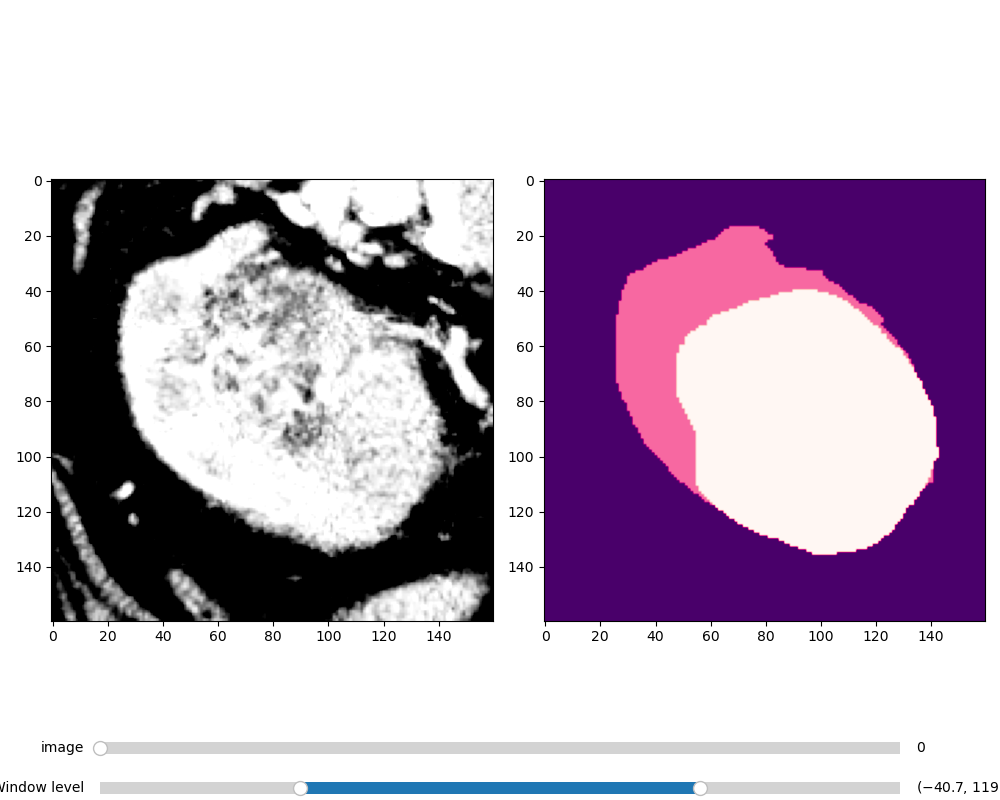

In [24]:
n = 7
ImageMaskViewer([imgs[n], masks[n]])

# Beware while creating patches: Class imbalance can be a problem if the organ size is much larger (more patches) than tumour inside.
## Next step reads each patch and stores bounding box information (and hence locates tumour inside it) in a file

In [29]:
cropped_mask_filenames = list(masks_fldr.glob("*pt"))
arguments = [[x, proj_defaults] for x in cropped_mask_filenames]

In [30]:
res_cropped = multiprocess_multiarg(
    func=bboxes_function_version, arguments=arguments, num_processes=24, debug=False
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 470/470 [00:06<00:00, 76.38it/s]


In [31]:
stats_fn = output_folder / "bboxes_info"
save_dict(res_cropped, stats_fn)

In [ ]:
bboxes_stage2 = load_dict(stats_fn)
bbox = bboxes_stage2[0]
pp(bbox)

## Utility function: calculate_patient_bbox. This crops the image to just the patient, getting rid of voxels of air outside (typically value <0; you set a higher threshold)

In [ ]:
filename = [fn for fn in stage0_files if "71" in str(fn)][0]
t = torch.load(filename)
img, mask = t["img"], t["mask"]

In [ ]:
lims = calculate_patient_bbox(img, 1)
print(
    "Shape of whole image: {0} \nShape of patient only: {1}".format(
        img.shape, img[lims].shape
    )
)
ImageMaskViewer([img, img[lims]], data_types=["img", "img"])

# Optional

##  Creating tumour examples at original desired spacings. These can be used for data augmentation while generating stage1 patches (at same res) %%

In [ ]:


folder = proj_defaults.stage0_folder
outfolder = folder / ("tumour_only")
maybe_makedirs(outfolder)
label = "tumour"
bboxes = load_dict(folder / "bboxes_info")
args = [[outfolder, info, "tumour"] for info in bboxes]

In [ ]:
a = multiprocess_multiarg(
    get_cropped_label_from_bbox_info, args, multiprocess=True, debug=False
)

##  Creating tumour examples at stage1 low-resolution. These can be used for data augmentation

In [ ]:

outfolder = stage1_subfolder.parent / ("tumour_only")
maybe_makedirs(outfolder)
label = "tumour"
bboxes = load_dict(outfolder.parent / "bboxes_info")
args = [[outfolder, info, "tumour"] for info in bboxes]

In [ ]:
a = multiprocess_multiarg(
    get_cropped_label_from_bbox_info, args, multiprocess=True, debug=False
)

# View a tumour-only example

In [ ]:
mask_fn = next(outfolder.glob("*pt"))
tnsr = torch.load(mask_fn)
ImageMaskViewer([tnsr["img"], tnsr["mask"]])

# Cropped to kidney dataset

In [ ]:
outfolder = proj_defaults.stage1_folder / ("cropped_separate_kidneys")

In [ ]:
caseid = "00002"
b = [bb for bb in stage0_bbox if bb["case_id"] == caseid][0]

In [ ]:
P = PatchGenerator(output_folder, patch_size, info=b)
P.create_patches_from_all_bboxes()

In [ ]:
######################################################################################

# Creating Patches separate kidney

In [ ]:
######################################################################################

# BBoxes need to only get 1 largest component per kidney , otherwise it introduces bugs if using default 2

In [ ]:
dusting_threshold_factor = 1  # as no subsampling in this dataset
filenames = list(output_folder.glob("*.pt"))
label_settings = proj_defaults.mask_labels
label_settings[0]["k_largest"] = 1

arguments = [
    [x, proj_defaults, label_settings, dusting_threshold_factor] for x in filenames
]
res_cropped = multiprocess_multiarg(
    func=bboxes_function_version, arguments=arguments, num_processes=16, debug=False
)
save_dict(res_cropped, output_folder.parent / "bboxes_info")

# Troubleshooting:
## Examining nifty file of any case showing strange intensity profile at stage0

In [ ]:
nii_fns = list((proj_defaults.raw_data_folder / ("imagesTr")).glob("*"))
img_fn = [fn for fn in nii_fns if case_id in str(fn)][0]

In [ ]:
num_processes = 16
argslist = [
    [
        props,
        R.mask_resize_func,
        R.proj_defaults,
        R.global_properties,
        R.label_priority,
        R._spacings,
        True,
        True,
    ]
    for props in R.raw_dataset_properties
]
args = [tt for tt in argslist if tt[0]["case_id"] == case_id][0]
results = multiprocess_multiarg(
    func=niipair_to_torch,
    arguments=argslist,
    num_processes=num_processes,
    multiprocess=multiprocess,
    debug=debug,
)

In [ ]:
img = nii_sitk_to_np(args[0]["properties"]["img_file"])
mask = nii_sitk_to_np(args[0]["properties"]["mask_file"])
ImageMaskViewer([img, mask])

# Splitting dict files into separate img mask tensor files
in_fldr = output_folder / ("64_160_160/volumes")
im = tensors_from_dict_file(tnsrs[0])
tnsrs = list(in_fldr.glob("*pt"))
outfldr = in_fldr.parent
args = [[tnsr, outfldr, False] for tnsr in tnsrs]

In [ ]:
def move_tnsrs_to_separate(infile, outfldr, overwrite=False):
    name = infile.name
    output_filenames = [outfldr / x / name for x in ("imagesTr", "masksTr")]
    if any(write_files_or_not(output_filenames, overwrite)) == True:
        im = tensors_from_dict_file(infile)
        [torch.save(x, y) for x, y in zip(im, output_filenames)]
        return 1
    else:
        return 0

In [ ]:
res = multiprocess_multiarg(
    func=move_tnsrs_to_separate, arguments=args, num_processes=20, debug=False
)

In [ ]:
output_folder = proj_defaults.stage2_folder
masks_fldr = output_folder / ("64_160_160/masksTr")
filenames = list(masks_fldr.glob("*pt"))
label_settings = proj_defaults.mask_labels
arguments = [[x, proj_defaults, 1, label_settings] for x in filenames]
bboxes_info = multiprocess_multiarg(
    func=bboxes_function_version, arguments=arguments, num_processes=16, debug=False
)

In [ ]:

bbox_fn = masks_fldr.parent / ("bboxes_info")
save_dict(bboxes_info, bbox_fn)

pp(bboxes_info[1])